In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Task 6

In [2]:
# read modified_data/
df_demand_log = pd.read_csv('modified_data/df_demand_log_t5.csv')
df_demand_log.rename(columns={'Jar Size  (vol. ounces)': 'jarSize'}, inplace=True)
df_demand_log.head()

,DemandID,Demand Request Date,Mix,jarSize,State,Quantity,Earliest Delivery Date,Preferred Delivery Date,Latest Delivery Date,Earliest Acceptable Shipping Date,Preferred Shipping Date,Latest Acceptable Shipping Date,MinOrderToShip,PrefOrderToShip,MaxOrderToShip,Smoothed Daily Demand
0,1,2021-01-01,Apple-Mango,8,Maryland,1,2021-01-01,2021-01-04,2021-01-07,2020-12-27,2020-12-30,2021-01-02,-5,-2,1,0.142857
1,39,2021-01-01,Orange-Passionfruit,32,Maryland,1,2021-01-01,2021-01-03,2021-01-03,2020-12-27,2020-12-29,2020-12-29,-5,-3,-3,0.333333
2,53,2021-01-01,Grape-Pomegranate,8,Maryland,1,2021-01-02,2021-01-07,2021-01-18,2020-12-28,2021-01-02,2021-01-13,-4,1,12,0.058824
3,125,2021-01-02,Cherry-Lime,32,Maryland,1,2021-01-03,2021-01-06,2021-01-08,2020-12-29,2021-01-01,2021-01-03,-4,-1,1,0.166667
4,182,2021-01-02,Strawberry-Kiwi,32,Maryland,1,2021-01-02,2021-01-03,2021-01-06,2020-12-28,2020-12-29,2021-01-01,-5,-4,-1,0.200000


In [3]:
# Query where orders are impossible to fulfill
lost_demand = df_demand_log.query('MaxOrderToShip < 0')
acheivable_demand = df_demand_log.query('MaxOrderToShip >= 0')

# Percentage of lost demand
lost_demand_percentage = lost_demand['Quantity'].sum() / df_demand_log['Quantity'].sum() * 100

print(f'Percentage of lost demand: {lost_demand_percentage:.2f}%')

Percentage of lost demand: 25.21%


About 25% of the volume of demand is lost due shipping timelines where the mix that was order would have to be shipped date before the day of request, or earlier. Depending on the responsiveness of the supply chain, this could potentially make day of shipping or shortly after impossible as well.

# Task 7

In [4]:
production_capacity = pd.read_excel('FruitSoul Production and Materials Characteristics and Costs.xlsx', sheet_name='Center Capacity', header=2)
production_capacity.rename(columns={'Unnamed: 1': 'Center', 'Unnamed: 7': "Unit"}, inplace=True)
production_capacity.drop(columns=['Unnamed: 0'], inplace=True)

## Mixing Demand History

Because mixing demand is measured in ounces, it's demand is not exactly in line with packaging and bottling demand.

### Demand History: Ounces

In [5]:
# Create total ounces columns
acheivable_demand['ozOfProduct'] = acheivable_demand['Quantity'] * acheivable_demand['jarSize']

# Preferred Demand History
preferred_ounces_demand = acheivable_demand.groupby(["Preferred Shipping Date"]).agg({"ozOfProduct": "sum"}).reset_index().rename(columns={"jarSize": "Ounces Demand"})

# Earliest Arrival Demand History
early_ounces_demand = acheivable_demand.groupby(["Earliest Acceptable Shipping Date"]).agg({"ozOfProduct": "sum"}).reset_index().rename(columns={"jarSize": "Ounces Demand"})

# Latest Arrival Demand History
late_ounces_demand = acheivable_demand.groupby(["Latest Acceptable Shipping Date"]).agg({"ozOfProduct": "sum"}).reset_index().rename(columns={"jarSize": "Ounces Demand"})

# Smoothed Arrival Demand History

def demand_probability(row, col_name='Quantity'):
    preferred_date = pd.to_datetime(row['Preferred Shipping Date'])
    earliest_date = pd.to_datetime(row['Earliest Acceptable Shipping Date'])
    latest_date = pd.to_datetime(row['Latest Acceptable Shipping Date'])
    
    # Calculate the standard deviation (earliest/latest represent ±2 standard deviations)
    std_dev = (latest_date - earliest_date).days / 4
    
    # Ensure std_dev is at least 1 to avoid division by zero
    std_dev = max(std_dev, 1)
    
    # Initialize empty list for smoothed demand distribution
    demand_distribution = []
    
    # Compute cumulative probabilities for the range of acceptable shipping dates
    for day in pd.date_range(earliest_date, latest_date):
        # CDF at the start and end of the day
        cdf_start = norm.cdf((day - pd.Timedelta(days=0.5) - preferred_date).days, scale=std_dev)
        cdf_end = norm.cdf((day + pd.Timedelta(days=0.5) - preferred_date).days, scale=std_dev)
        
        # Cumulative probability for the 24-hour period (between start and end of the day)
        daily_probability = cdf_end - cdf_start
        
        demand_distribution.append({
            'Date': day,
            'Mix': row['Mix'],
            'Probability': daily_probability
        })
    
    # Convert list to DataFrame
    df_demand_distribution = pd.DataFrame(demand_distribution)

    if len(df_demand_distribution) == 0:
        return pd.DataFrame(columns=['Date', 'Mix', 'Smoothed Daily Demand'])
    
    # Normalize probabilities to sum up to 1, then scale to match total quantity
    df_demand_distribution['smoothedDailyDemand'] = (df_demand_distribution['Probability']) * row[col_name]
    
    return df_demand_distribution[['Date', 'Mix', 'smoothedDailyDemand']]

# Apply the function to each row in the demand log and concatenate the results
smoothed_ounces_demand = pd.concat([demand_probability(row, col_name = 'ozOfProduct') for _, row in acheivable_demand.iterrows()])

/var/folders/1g/8vbqswf55db7cq6z4fs9npbr0000gn/T/ipykernel_52965/2866100714.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acheivable_demand['ozOfProduct'] = acheivable_demand['Quantity'] * acheivable_demand['jarSize']


### Demand History: Jars

Because packaging and bottling demand is measured in jar, the demand will be identical for each order.

In [6]:
# Preferred Demand History
preferred_jars_demand = acheivable_demand.groupby(["Preferred Shipping Date"]).agg({"Quantity": "sum"}).reset_index().rename(columns={"jarSize": "Jars Demand"})
# Earliest Arrival Demand History
early_jars_demand = acheivable_demand.groupby(["Earliest Acceptable Shipping Date"]).agg({"Quantity": "sum"}).reset_index().rename(columns={"jarSize": "Jars Demand"})
# Latest Arrival Demand History
late_jars_demand = acheivable_demand.groupby(["Latest Acceptable Shipping Date"]).agg({"Quantity": "sum"}).reset_index().rename(columns={"jarSize": "Jars Demand"})

# Smoothed Arrival Demand History
smoothed_jars_demand = pd.concat([demand_probability(row, col_name = 'Quantity') for _, row in acheivable_demand.iterrows()])

### Adjust demand dates for off days


In [7]:
# Function to check if a date is Labor Day
def is_labor_day(date):
    if date.strftime('%m') == '09' and date.strftime('%d') <= '07' and date.weekday() == 0:
        return True
    return False

# Define the date for the 4th of July 
july_4th = '07-04'

# Function to adjust dates for earliest or latest shipping dates on Sundays, labor days, or 4th of July
def adjust_date(date, type='e'):
    """
    Adjust the date based on the type:
    'e' for Earliest Acceptable Shipping Date,
    'l' for Latest Acceptable Shipping Date
    """
    if type == 'e':
        if date.weekday() == 6:
            date = date + pd.Timedelta(days=1)
        if is_labor_day(date) or date.strftime('%m-%d') == july_4th:
            date = date + pd.Timedelta(days=1)
            if date.weekday() == 6:
                date = date + pd.Timedelta(days=1)
        return date
    
    if type == 'l':
        if is_labor_day(date) or date.strftime('%m-%d') == july_4th:
            date = date - pd.Timedelta(days=1)
        if date.weekday() == 6:
            date = date - pd.Timedelta(days=1)
            if is_labor_day(date) or date.strftime('%m-%d') == july_4th:
                date = date - pd.Timedelta(days=1)
        return date

    return date

# Adjust the dates
smoothed_jars_demand['Date'] = smoothed_jars_demand['Date'].apply(lambda x: adjust_date(x, 'e'))
smoothed_ounces_demand['Date'] = smoothed_ounces_demand['Date'].apply(lambda x: adjust_date(x, 'e'))

# Function to check if a date is a Sunday, Labor Day, or the 4th of July
def is_special_day(date):
    return date.weekday() == 6 or is_labor_day(date) or date.strftime('%m-%d') == july_4th

# Function to move the date forward by one day if it is a special day
def adjust_preferred_shipping_date(date):
    if is_special_day(date):
        date += pd.Timedelta(days=1)
        if is_special_day(date):
            date -= pd.Timedelta(days=2)
    return date

# Apply the function to the Preferred Shipping Date column
smoothed_jars_demand['Date'] = smoothed_jars_demand['Date'].apply(adjust_preferred_shipping_date)
smoothed_ounces_demand['Date'] = smoothed_ounces_demand['Date'].apply(adjust_preferred_shipping_date)

In [8]:
smoothed_jars_demand_date = smoothed_jars_demand.groupby('Date').agg({'smoothedDailyDemand': 'sum'}).reset_index()
smoothed_ounces_demand_date = smoothed_ounces_demand.groupby('Date').agg({'smoothedDailyDemand': 'sum'}).reset_index()

# Task 8

## Identify production capacity 

In [148]:
def identify_production_demand(demand_vector, s):
    s_pctile_demand  = np.percentile(np.array(demand_vector), 100-s)
    return s_pctile_demand

def identify_max_daily_production(production_capacity, center_name = "Mixing"):
    max_shift_production = production_capacity[production_capacity['Center'] == center_name][5].values[0]
    max_daily_production = max_shift_production * 2 # 2 shifts per day
    return max_daily_production

def identify_cells_needed(demand, max_daily_production):
    cells_needed = np.ceil(demand / max_daily_production)
    return cells_needed

In [149]:
jars = smoothed_jars_demand_date.rename(columns={'smoothedDailyDemand': 'jarsDemand'})
ounces = smoothed_ounces_demand_date.rename(columns={'smoothedDailyDemand': 'ouncesDemand'})

# Merge on Date
production_demand = jars.merge(ounces, on='Date', how='left')

# Fill NA values with 0\
production_demand.fillna(0, inplace=True)

## Identify total cells needed

In [212]:
def identify_total_cells_needed(production_demand, production_capacity, center_name, s):
    unit = production_capacity[production_capacity['Center'] == center_name]['Unit'].values[0]

    if unit == "Jars":
        demand_vector = production_demand['jarsDemand']
    else:
        demand_vector = production_demand['ouncesDemand']

    s_pctile_demand = identify_production_demand(demand_vector, s)
    max_daily_production = identify_max_daily_production(production_capacity, center_name)
    cells_needed = identify_cells_needed(s_pctile_demand, max_daily_production)
    
    return cells_needed

## Optimize Daily Set-Up

In [213]:
# Create function to return demand for a given date
def get_demand(date, production_demand, demandColumnName = 'jarsDemand'):
    return production_demand[(production_demand['Date'] == date)][demandColumnName].values[0]

In [309]:
# Sample date from production_demand['Date']
random_date = production_demand['Date'].sample().values[0]

# Get demand for the random date
date_demand = get_demand(random_date, production_demand, 'ouncesDemand')

# Identify active cells needed to account for all demand
def active_cells(date, yearly_cell_plan, production_capacity, production_demand, centerName):
    if centerName == 'Mixing':
        demandType = 'ouncesDemand'
    else:
        demandType = 'jarsDemand'

    date_demand = get_demand(date, production_demand, demandType)

    active_cells_needed  = np.ceil(date_demand / identify_max_daily_production(production_capacity, centerName))

    year = date.year
    available_cells = yearly_cell_plan[yearly_cell_plan['Year'] == year][centerName].values[0]
    active_cells = np.minimum(active_cells_needed, available_cells)

    remaining_demand = date_demand - ((active_cells  - 1) * identify_max_daily_production(production_capacity, centerName))

    # Find workers needed function
    def workers_needed(demand, production_capacity, centerName):
        new_demand = demand/2 # 2 shifts
        filtered_production_cap = production_capacity[production_capacity['Center'] == centerName]
        # Drop first and last columns
        filtered_production_cap = filtered_production_cap.drop(columns=['Center', 'Unit'])
        # Find first row with capacity greater than demand, iterating through columns. If true, return column name
        for col in filtered_production_cap.columns[1:]:
            if new_demand <= filtered_production_cap[col].values[0]:
                return col
            
    additional_workers = workers_needed(remaining_demand, production_capacity, centerName)

    return active_cells, additional_workers

In [310]:
def create_yearly_cell_plan(production_demand, production_capacity, s, centerNames=["Mixing", "Bottling", "Packing"]):
    cells_needed_df = pd.DataFrame()  # Create an empty DataFrame to store the results
    
    for centerName in centerNames:
        cells_needed = [] 
        
        distinct_years = production_demand['Date'].dt.year.unique()
        for year in distinct_years:
            year_demand = production_demand[production_demand['Date'].dt.year == year]
            cells_needed.append(identify_total_cells_needed(year_demand, production_capacity, centerName, s))
        
        center_df = pd.DataFrame({centerName: cells_needed})
        cells_needed_df = pd.concat([cells_needed_df, center_df], axis=1)

    cells_needed_df.insert(0, "Year", distinct_years)
        
    return cells_needed_df

### Finding results

In [318]:
def find_worker_production(num_workers, production_capacity, centerName):
    if num_workers == None:
        num_workers = 2
    filtered_production_cap = production_capacity[production_capacity['Center'] == centerName]
    filtered_production_cap = filtered_production_cap[num_workers]
    return filtered_production_cap.values[0]

In [319]:
def create_active_cells_plan(production_capacity, yearly_cell_plan, production_demand):
    active_cells_df = pd.DataFrame()
    date_range = production_demand['Date'].unique()

    for date in date_range:
        for cell in ['Mixing', 'Bottling', 'Packing']:
            cells_needed, workers_in_last_cell = active_cells(date, yearly_cell_plan, production_capacity, production_demand, cell)
            if cell == 'Mixing':
                demand = get_demand(date, production_demand, 'ouncesDemand')
            else:
                demand = get_demand(date, production_demand, 'jarsDemand')
            
            max_daily_production = identify_max_daily_production(production_capacity, cell)
            workers_production = find_worker_production(workers_in_last_cell, production_capacity, cell)
            temp_df = pd.DataFrame({'Date': [date], 'centerName': [cell], 'cellsNeeded': [cells_needed], 'workersInLastCell': [workers_in_last_cell], 'demand': [demand]})
            
            temp_df['productionCapacity'] = (cells_needed - 1) * max_daily_production + workers_production
            temp_df['production'] = np.where(temp_df['productionCapacity'] > temp_df['demand'], temp_df['demand'], temp_df['productionCapacity'])
            
            temp_df['demandUnit'] = 'Jars' if cell == 'Bottling' or cell == 'Packing' else 'Ounces'
            
            active_cells_df = pd.concat([active_cells_df, temp_df])
    
    return active_cells_df

In [321]:
def process_daily_table(s x, y):    
    x = create_yearly_cell_plan(production_demand, production_capacity, s)

    y = create_active_cells_plan(production_capacity, production_demand)

    # Create 'Year' column from 'Date'
    y['Year'] = y['Date'].dt.year

    # Pivot x longer based on ['Mixing', 'Bottling', 'Packing']
    x_long = x.melt(id_vars=['Year'], var_name='Center', value_name='totalCells')

    # Merge y with x_long 
    z = y.merge(x_long, left_on=['Year', 'centerName'], right_on=['Year', 'Center'], how = 'left')

    z.drop(columns=['centerName', 'Year'], inplace=True)

    z['cellsNeeded'] = np.where(z['totalCells'] > z['cellsNeeded'], z['totalCells'], z['cellsNeeded'])

    return z

In [322]:
production_costs = pd.read_excel('FruitSoul Production and Materials Characteristics and Costs.xlsx', sheet_name='Production Costs', header=2)
production_costs.drop(columns=['Unnamed: 0'], inplace=True)
production_costs.rename(columns={'Unnamed: 1': 'Center', 'Unnamed: 2': 'Set-Up Costs', 'Unnamed: 3': 'Operating Daily Costs'}, inplace=True)

In [323]:
def calculate_setup_costs(yearly_cell_df):
    setup_cost = yearly_cell_df.copy()
    setup_cost_dict = {'Mixing': 15000, 'Bottling': 8000, 'Packing': 5000}

    setup_cost['Mixing'] = setup_cost['Mixing'] * setup_cost_dict['Mixing']
    setup_cost['Bottling'] = setup_cost['Bottling'] * setup_cost_dict['Bottling']
    setup_cost['Packing'] = setup_cost['Packing'] * setup_cost_dict['Packing']

    # Pivot longer to 2 columns ["Date", "Cost Description", "Cost"] from one for each "Mixing", "Bottling", "Packing" and "Year"
    setup_cost.rename(columns={'Year': 'Date'}, inplace=True)
    setup_cost_long = setup_cost.melt(id_vars=['Date'], var_name='Cost Description', value_name='Cost')

    # Add "Set-Up Costs" to "Cost Description"
    setup_cost_long['Cost Description'] = setup_cost_long['Cost Description'] + ' Set-Up Costs'

    # Sort the DataFrame by 'Cost Description' and 'Date' to ensure proper grouping
    setup_cost_long = setup_cost_long.sort_values(by=['Cost Description', 'Date'])

    # Group by 'Cost Description' and calculate the difference (additional spending)
    setup_cost_long['Additional Cost'] = setup_cost_long.groupby('Cost Description')['Cost'].diff().fillna(setup_cost_long['Cost'])
    
    setup_cost_long['Cost'] = setup_cost_long['Additional Cost']
    setup_cost_long['Cumulative Cost'] = setup_cost_long.groupby('Cost Description')['Cost'].cumsum()

    return setup_cost_long

In [324]:
def calculate_cell_operating_costs(active_cells_df):
    operating_cost = active_cells_df.copy()
    operating_cost_dict = {'Mixing': 400, 'Bottling': 350, 'Packing': 600}

    # Apply a function to each row to calculate the cost
    def calculate_cost(row):
        return row['cellsNeeded'] * operating_cost_dict[row['Center']]
    
    operating_cost['Cost'] = active_cells_df.apply(calculate_cost, axis=1)

    # Rename the existing 'Cost' column temporarily to avoid conflict during melt
    operating_cost.rename(columns={'Cost': 'dailyCost'}, inplace=True)

    # Pivot longer Center column where values are the "Cost"
    operating_cost_long = operating_cost.melt(id_vars=['Date', 'Center'], value_vars=['dailyCost'], var_name='Cost Description', value_name='Cost')

    # Add "Operating Daily Costs" to "Cost Description"
    operating_cost_long['Cost Description'] = operating_cost_long['Center'] + ' Cell Daily Costs'

    # Group by "Date" (parse the year) and "Cost Description" and sum the "Cost"
    yearly_data = operating_cost_long.copy()
    yearly_data['Date'] = pd.to_datetime(yearly_data['Date'])
    yearly_data['Date'] = yearly_data['Date'].dt.year

    yearly_summary = yearly_data.groupby(['Date', 'Cost Description']).agg({'Cost': 'sum'}).reset_index()

    return operating_cost_long[['Date', 'Cost Description', 'Cost']], yearly_summary


In [325]:
def calculate_labor_costs(active_cells_df):
    labor_cost = active_cells_df.copy()
    labor_cost.rename(columns={'date': 'Date'}, inplace=True)
    labor_cost['totalWorkers'] = 2 * (((labor_cost['cellsNeeded'] - 1) * 5) + labor_cost['workersInLastCell']) # 2 shifts
    # We will operate so that on days where we are fully staffed in packaging, 80% of the workers are full-time
    # First identify the maximum workers needed in Packing, this will still ensure the total workforce is at least 70% full time
    max_packing_workers = labor_cost[labor_cost['Center'] == 'Packing']['totalWorkers'].max()
    full_time_packing_workers = np.ceil(0.7 * max_packing_workers)
    labor_cost['fullTimeWorkers'] = np.where(labor_cost['Center'].isin(['Mixing', 'Bottling']), labor_cost['totalWorkers'], full_time_packing_workers)
    # If the number of totalWorkers is less than or equal to the # of full-time workers, we will have all workers as full-time
    labor_cost['fullTimeWorkers'] = np.where(labor_cost['totalWorkers'] <= full_time_packing_workers, labor_cost['totalWorkers'], labor_cost['fullTimeWorkers'])
    
    labor_cost['partTimeWorkers'] = labor_cost['totalWorkers'] - labor_cost['fullTimeWorkers']

    # Using heuristic that each worker will only work where they specialize, with no overtime
    labor_cost_dict = {'Mixing': 20, 'Bottling': 15, 'Packing': 25}

    # Apply a function to each row to calculate the cost, part-time workers are 1.15x more expensive than full-time workers
    # Not necessarily the wages, but including costs of lost production, training, etc for part-time workers
    def calculate_cost(row):
        return (row['fullTimeWorkers'] * labor_cost_dict[row['Center']] + row['partTimeWorkers'] * 1.15 * labor_cost_dict[row['Center']])
    
    labor_cost['Cost'] = labor_cost.apply(calculate_cost, axis=1)
    labor_cost['Cost Description'] = labor_cost['Center'] + ' Labor Costs'
    
    active_cells_df['fullTimeWorkers'] = labor_cost['fullTimeWorkers']
    active_cells_df['partTimeWorkers'] = labor_cost['partTimeWorkers']

    labor_summary = labor_cost.copy()
    labor_summary['Date'] = pd.to_datetime(labor_summary['Date'])
    labor_summary['Date'] = labor_summary['Date'].dt.year
    labor_summary = labor_summary.groupby(['Date', 'Cost Description']).agg({'Cost': 'sum'}).reset_index()

    return labor_cost[['Date', 'Cost Description', 'Cost']], active_cells_df, labor_summary

In [326]:
def create_cost_summary(df):
    # Split 'Cost Description' into 'Center' and 'Cost Type'
    df['Center'] = df['Cost Description'].str.split(' ').str[0]
    df['Cost Type'] = df['Cost Description'].str.split(' ').str[1]
    
    pivoted_df = df.pivot(index=['Date', 'Cost Type'], columns='Center', values='Cost')

    pivoted_df.reset_index(inplace=True)
    
    pivoted_df.columns.name = None
    
    # Rename Date to Year
    pivoted_df.rename(columns={'Date': 'Year'}, inplace=True)

    return pivoted_df

In [329]:
def create_service_level_plan(s, production_demand, production_capacity, production_costs):
    yearly_cell_df = create_yearly_cell_plan(production_demand, production_capacity, s)
    active_cells_df = create_active_cells_plan(production_capacity, yearly_cell_df, production_demand)
    active_cells_df = process_daily_table(s, production_capacity, production_demand, yearly_cell_df, active_cells_df)
    cell_setup_costs = calculate_setup_costs(yearly_cell_df)
    cell_operating_costs, operating_summary = calculate_cell_operating_costs(active_cells_df)
    labor_costs, active_cells_df, labor_summary = calculate_labor_costs(active_cells_df)
    cost_summary = pd.concat([cell_setup_costs.drop(columns='Cumulative Cost'), operating_summary, labor_summary], axis=0)
    cost_summary = create_cost_summary(cost_summary)
    
    # Create dictionary of raw data tables to return
    raw_data = {
        'cell_setup_costs': cell_setup_costs,
        'cell_operating_costs': cell_operating_costs,
        'labor_costs': labor_costs
    }
    
    return active_cells_df, yearly_cell_df, raw_data, cost_summary

In [330]:
active_cells_plan, yearly_cell_plan, raw_tables, total_costs = create_service_level_plan(10, production_demand, production_capacity, production_costs)

1.0
1.0
3.0
5.0
1.0
1.0
1.0
2.0
3.0
1.0
1.0
2.0
3.0
5.0
1.0
1.0
1.0
3.0
5.0
1.0
1.0
1.0
2.0
3.0
1.0
1.0
2.0
3.0
5.0
1.0


TypeError: create_active_cells_plan() missing 1 required positional argument: 'production_demand'

## Dashboard

In [ ]:
active_cells_plan.query('cellsNeeded > totalCells')

,Date,cellsNeeded,workersInLastCell,demand,productionCapacity,production,demandUnit,Center,totalCells,fullTimeWorkers,partTimeWorkers
540,2021-07-26,2.0,2,7693.183685,8064.0,7693.183685,Ounces,Mixing,1.0,14.0,0.0
558,2021-08-02,2.0,2,6419.003781,8064.0,6419.003781,Ounces,Mixing,1.0,14.0,0.0
630,2021-08-30,2.0,2,7908.629844,8064.0,7908.629844,Ounces,Mixing,1.0,14.0,0.0
648,2021-09-07,2.0,3,10524.843602,8704.0,8704.000000,Ounces,Mixing,1.0,16.0,0.0
681,2021-09-20,2.0,2,9077.833071,8064.0,8064.000000,Ounces,Mixing,1.0,14.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2775,2023-12-18,6.0,4,36728.563974,34816.0,34816.000000,Ounces,Mixing,5.0,58.0,0.0
2777,2023-12-18,7.0,5,2063.963642,1950.0,1950.000000,Jars,Packing,5.0,70.0,0.0
2811,2024-01-01,3.0,2,13270.826104,14464.0,13270.826104,Ounces,Mixing,1.0,24.0,0.0
2812,2024-01-01,2.0,2,749.973349,875.0,749.973349,Jars,Bottling,1.0,14.0,0.0


In [ ]:
yearly_cell_plan

,Year,Mixing,Bottling,Packing
0,2020,1.0,1.0,1.0
1,2021,1.0,1.0,2.0
2,2022,3.0,2.0,3.0
3,2023,5.0,3.0,5.0
4,2024,1.0,1.0,1.0


In [ ]:
production_demand

,Date,jarsDemand,ouncesDemand
0,2020-12-28,7.693362,143.735140
1,2020-12-29,13.790215,257.541181
2,2020-12-30,23.725394,428.447712
3,2020-12-31,37.695940,650.007061
4,2021-01-01,52.841455,907.177359
...,...,...,...
951,2024-01-17,0.103070,1.831112
952,2024-01-18,0.036771,0.466783
953,2024-01-19,0.017915,0.217532
954,2024-01-20,0.008219,0.106294


In [ ]:
total_costs

,Year,Cost Type,Bottling,Mixing,Packing
0,2020,Cell,1400.0,1600.0,2400.0
1,2020,Labor,240.0,320.0,400.0
2,2020,Set-Up,8000.0,15000.0,5000.0
3,2021,Cell,113050.0,141600.0,387000.0
4,2021,Labor,21540.0,39640.0,128650.0
5,2021,Set-Up,0.0,0.0,5000.0
6,2022,Cell,225050.0,394800.0,610200.0
7,2022,Labor,76650.0,172240.0,225100.0
8,2022,Set-Up,8000.0,30000.0,5000.0
9,2023,Cell,336350.0,649600.0,1000200.0


### Yearly Dashboard

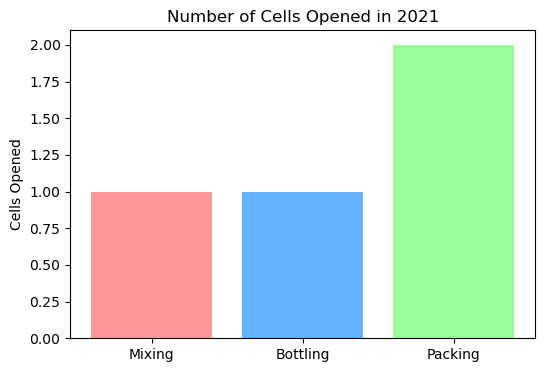

Total cells opened until 2021: 7.0


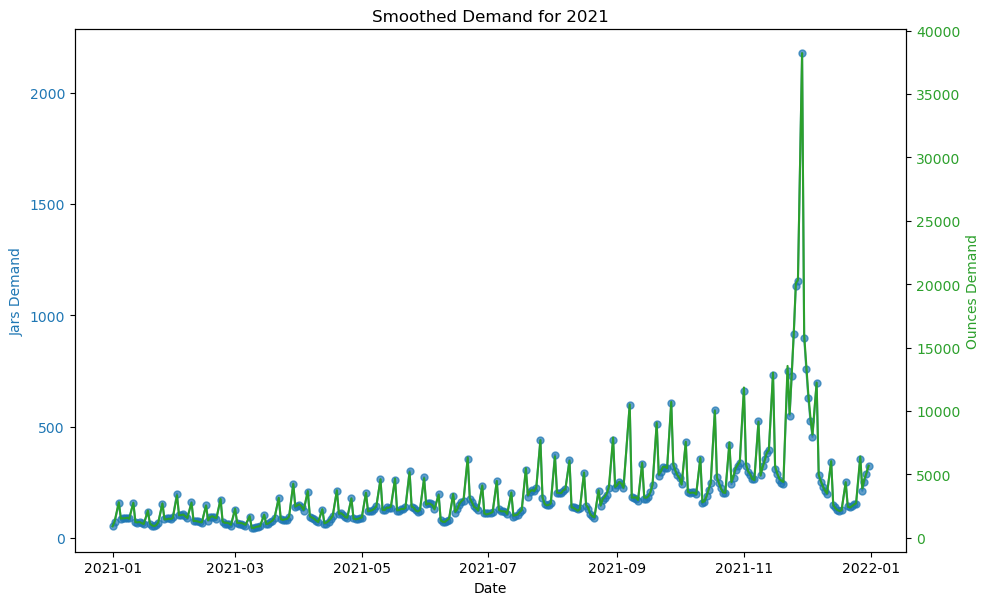

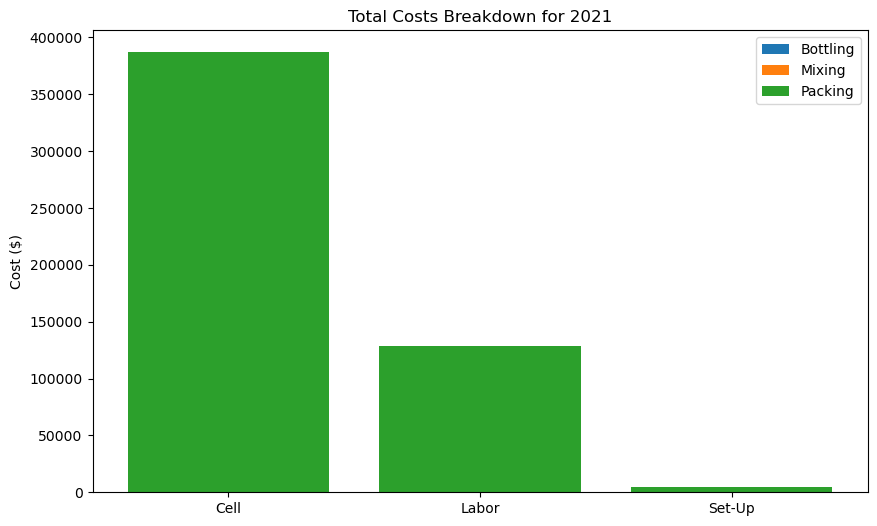

Total jars produced in 2021: 99686.2136515645
Total ounces produced in 2021: 838430.9643911311
Achieved service level (Jars) in 2021: 78.59%
Achieved service level (Ounces) in 2021: 74.92%


In [ ]:
import matplotlib.pyplot as plt

def plot_yearly_dashboard(year, active_cells_plan, yearly_cell_plan, total_costs, production_demand):
    # Step 1: Number of Cells Newly Opened Each Year & Total Cells Opened
    yearly_data = yearly_cell_plan[yearly_cell_plan['Year'] == year]
    total_cells_opened = yearly_data[['Mixing', 'Bottling', 'Packing']].sum(axis=1).values[0]

    # Assuming total cells opened are cumulative from previous years
    cumulative_cells = yearly_cell_plan[yearly_cell_plan['Year'] <= year][['Mixing', 'Bottling', 'Packing']].sum().sum()

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.bar(['Mixing', 'Bottling', 'Packing'], yearly_data.iloc[0, 1:], color=['#FF9999','#66B2FF','#99FF99'])
    ax.set_title(f'Number of Cells Opened in {year}')
    ax.set_ylabel('Cells Opened')
    plt.show()

    print(f"Total cells opened until {year}: {cumulative_cells}")

    # Step 2: Smoothed Demand Graph with Two Axes (Jars and Ounces)
    production_year = production_demand[production_demand['Date'].dt.year == year]
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Jars Demand', color='tab:blue')
    ax1.plot(production_year['Date'], production_year['jarsDemand'], color='tab:blue', label='Jars Demand', marker='o', alpha=0.7, markersize=5)
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('Ounces Demand', color='tab:green')  
    ax2.plot(production_year['Date'], production_year['ouncesDemand'], color='tab:green', label='Ounces Demand')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(f'Smoothed Demand for {year}')
    plt.show()

    # Step 3: Cost Summary for the Year
    total_costs_filtered = total_costs[total_costs['Year'] == year]

    fig, ax = plt.subplots(figsize=(10, 6))
    cost_types = ['Bottling', 'Mixing', 'Packing']
    for cost_type in cost_types:
        ax.bar(total_costs_filtered['Cost Type'], total_costs_filtered[cost_type], label=cost_type)

    ax.set_title(f'Total Costs Breakdown for {year}')
    ax.set_ylabel('Cost ($)')
    ax.legend()
    plt.show()

    # Step 4: Total Production & Achieved Service Level
    active_cells_year = active_cells_plan[active_cells_plan['Date'].dt.year == year]
    
    total_jars_produced = active_cells_year[active_cells_year['demandUnit'] == 'Jars']['production'].sum()
    total_ounces_produced = active_cells_year[active_cells_year['demandUnit'] == 'Ounces']['production'].sum()
    
    # Achieved service level = Total production / Total demand
    total_jars_demand = active_cells_year[active_cells_year['demandUnit'] == 'Jars']['demand'].sum()
    total_ounces_demand = active_cells_year[active_cells_year['demandUnit'] == 'Ounces']['demand'].sum()

    achieved_service_level_jars = total_jars_produced / total_jars_demand if total_jars_demand > 0 else 0
    achieved_service_level_ounces = total_ounces_produced / total_ounces_demand if total_ounces_demand > 0 else 0

    print(f"Total jars produced in {year}: {total_jars_produced}")
    print(f"Total ounces produced in {year}: {total_ounces_produced}")
    print(f"Achieved service level (Jars) in {year}: {achieved_service_level_jars:.2%}")
    print(f"Achieved service level (Ounces) in {year}: {achieved_service_level_ounces:.2%}")

# Example usage:
# Assuming active_cells_plan, yearly_cell_plan, total_costs, and production_demand are your DataFrames
plot_yearly_dashboard(2021, active_cells_plan, yearly_cell_plan, total_costs, production_demand)
